In [17]:
import tensorflow as tf 
%matplotlib inline 
import matplotlib.pylab as plt
import numpy as np
from keras.preprocessing import image

# task: classifcation cars
 * firebrigades
 * police cars
 * rescue cars

### Generator

In [18]:
train_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=0,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=(0.9, 1.1),
    horizontal_flip=True,
    vertical_flip=False
)

test_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [19]:
train_dir = './images'
validation_dir = './images'

IMG_HEIGHT, IMG_WIDTH = 224, 224
batch_size  = 32

train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH))

validation_data_gen = test_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=validation_dir,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH))

Found 459 images belonging to 3 classes.
Found 459 images belonging to 3 classes.


### found classes 

In [20]:
print(train_data_gen.class_indices)

{'fire': 0, 'police': 1, 'rescue': 2}


### display samples from training set


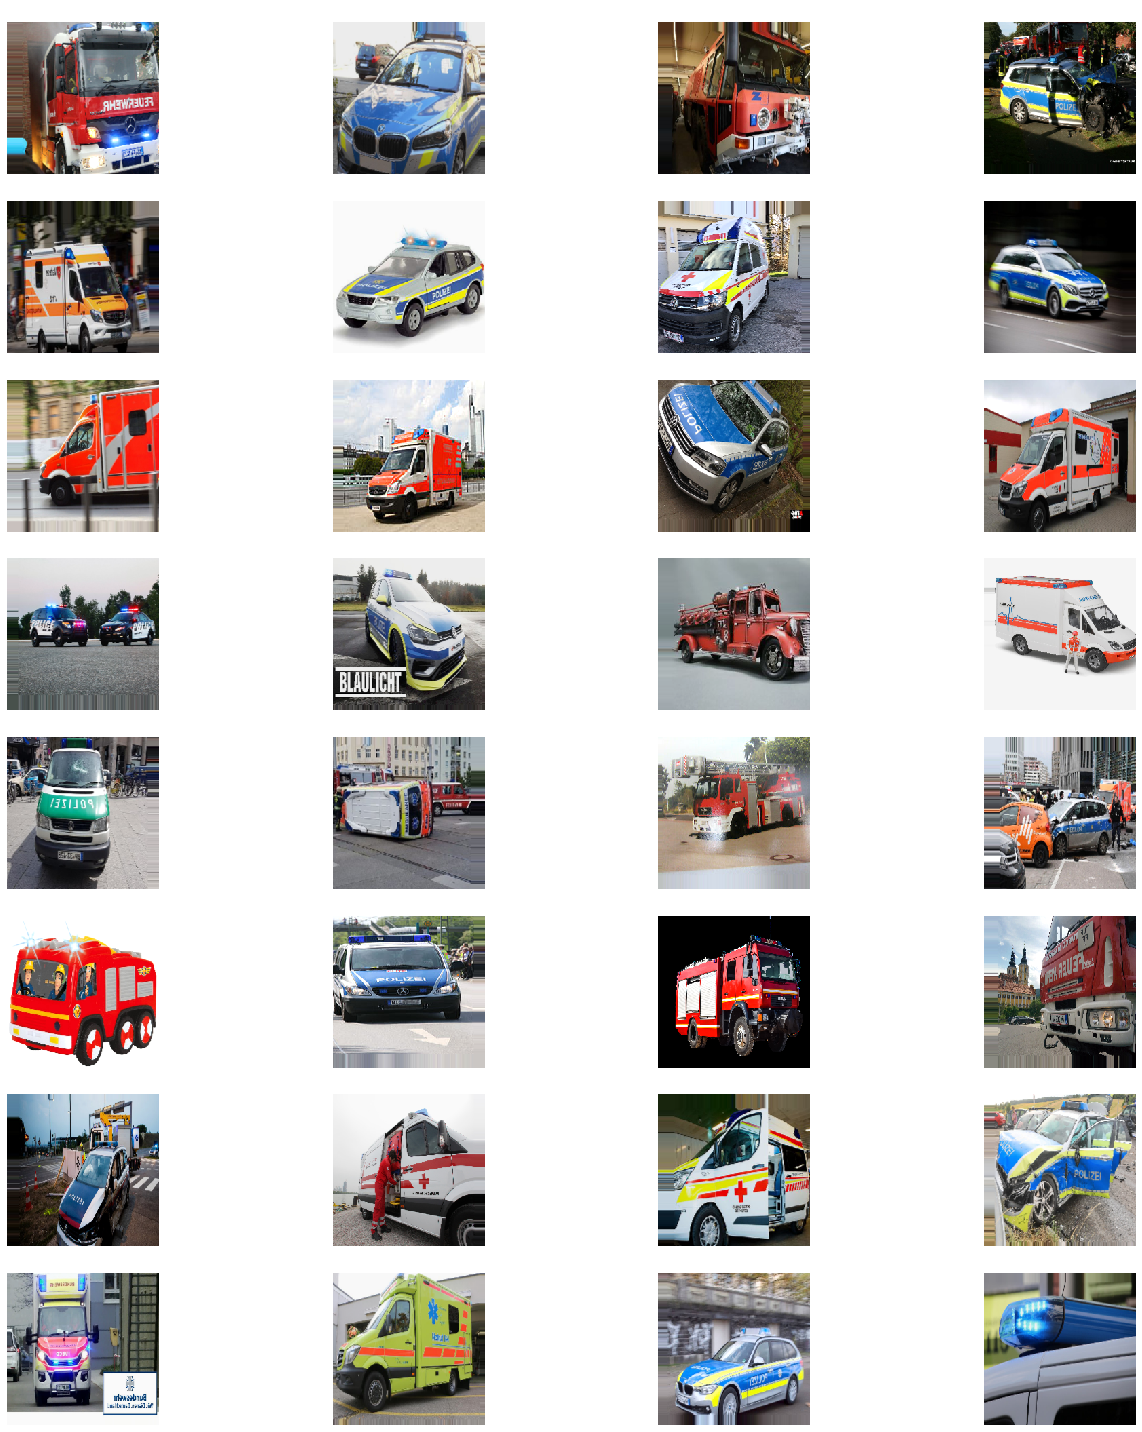

In [21]:
sample_training_images, labels = next(train_data_gen)
class_label = {v:k for k,v in train_data_gen.class_indices.items()}
fig, axes = plt.subplots(8, 4, figsize=(20,20))
axes = axes.flatten()
for img, label, ax in zip(sample_training_images, labels, axes):
    ax.set_title(class_label[np.argmax(label)])
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()

### pre-trained modelling

base_model = tf.keras.applications.resnet_v2.ResNet50V2(
        include_top=False,
        pooling='max',
        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
        weights='imagenet',
        classes=3)

In [22]:
#model = tf.keras.Sequential([
#    base_model,
#    tf.keras.layers.Dense(512, 'relu'),
#    tf.keras.layers.Dense(256, 'relu'),
#    tf.keras.layers.Dense(train_data_gen.num_classes, 'softmax')
#])
    
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, 'relu'),
    tf.keras.layers.Dense(train_data_gen.num_classes, 'softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 50176)             0

## helper function

In [33]:
def skip_broken_images(gen):
    while True:
        try:
            data, labels = next(gen)
            yield data, labels
        except GeneratorExit:
            break
        except:
            print("skip broken image")
            pass

In [34]:
snapshot_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="./snapshots",
    verbose=1)

## only fully connected layers

In [36]:
#for layer in base_model.layers:
#    layer.trainable = False
    
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

history = model.fit_generator(
    skip_broken_images(train_data_gen),
    steps_per_epoch=14, #use way more steps here: number of samples / batch size
    epochs=30, #use way more or use EarlyStopping callback
    validation_data=skip_broken_images(validation_data_gen),
    validation_steps=5,
    callbacks=[snapshot_callback]
)

Epoch 1/30


ValueError: A target array with shape (32, 3) was passed for an output of shape (None, 1) while using as loss `categorical_crossentropy`. This loss expects targets to have the same shape as the output.

In [0]:
plt.plot(history.history['loss'])

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(30)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [0]:
model.save('cars.h5')

* test the data
*  calculate accuracy 

In [0]:
image_path="./images/fire/1.Feuerwehr-06.jpeg"
img = image.load_img(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
plt.imshow(img)
img = tf.image.decode_jpg(img)
img = tf.cast(img, tf.float32)
#result = model.predict_classes(img)
#print(class_label[np.argmax(result)])

In [0]:
image_path="./images/police/3.2018121220pi20amstetten2c20foto201.jpg"
img = image.load_img(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
plt.imshow(img)
#result = model.predict_classes(img)
#print(class_label[np.argmax(result)])

In [0]:
sample_training_images, labels = next(train_data_gen)
class_label = {v:k for k,v in train_data_gen.class_indices.items()}
fig, axes = plt.subplots(8, 4, figsize=(20,20))
axes = axes.flatten()
for img, ax in zip(sample_training_images, axes):
    img2 = np.expand_dims(img, axis=0)
    result = model.predict_classes(img2)
    print(result)
    ax.set_title(class_label[np.argmax(result)])
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()

In [0]:
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions

In [0]:
image_path="./images/fire/33.596_678227509643.jpg"
img = image.load_img(image_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
preds = model.predict(x)
 
# decode the results into a list of tuples (class, description, probability)
print(preds)

class_label[np.argmax(preds)]